## Imports

In [50]:
import json
import os
import sys

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.initializers import RandomUniform, RandomNormal, HeNormal, GlorotUniform, Constant, Zeros
from keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2


dir_parts = os.getcwd().split(os.path.sep)
root_index = dir_parts.index('ML-B')
root_path = os.path.sep.join(dir_parts[:root_index + 1])
sys.path.append(root_path + '/code/')
from data.data_config import Dataset
from data.data_utils import load_monk, load_cup, store_monk_result, store_cup_result
from hyperparameter_tuning import grid_search, random_search, tuning_search_top_configs
from training.solver import Solver

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# NN
In this notebook we implement and test a custom (feed-forward) Neural Network w.r.t. the tasks at hand, i.e. the three MONK's problem and the CUP dataset.

Specifically:
- **get_nn_classifier(...)**: defines the NN classifier for the MONK's problems;
- **get_nn_regressor(...)**: defines the NN regressor for the CUP dataset.

## Settings

In [ ]:
MODEL_NAME = 'NN'
VAL_SPLIT = 0.1 # validation split percentage
INTERNAL_TEST_SPLIT = 0.1 # internal test split percentage
RANDOM_STATE = 128 # reproducibility
N_SPLITS = 5 # cross-validation

## Path

In [ ]:
# Directories
results_dir = root_path + '/results/' + MODEL_NAME

# Filepaths (MONK)
m1_dev_path, m1_test_path = Dataset.MONK_1.dev_path, Dataset.MONK_1.test_path # MONK 1
m2_dev_path, m2_test_path = Dataset.MONK_2.dev_path, Dataset.MONK_2.test_path # MONK 2
m3_dev_path, m3_test_path = Dataset.MONK_3.dev_path, Dataset.MONK_3.test_path # MONK 3

# Filepaths (CUP)
cup_dev_path, cup_test_path = Dataset.CUP.dev_path, Dataset.CUP.test_path

# MONK-1

In [ ]:
# Load MONK-1
x_dev_m1, y_dev_m1, x_test_m1, y_test_m1 = load_monk(m1_dev_path, m1_test_path)

## Model

In [ ]:
def get_nn_classifier(hparams):
    initializer = GlorotUniform(seed=RANDOM_STATE) # Glorot (Xavier)
    
    model = Sequential([
        Dense(hparams['h_dim'], activation='tanh', input_shape=(17,), kernel_initializer=initializer),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(hparams['reg']))
    ])
    
    optimizer = SGD(learning_rate=hparams['lr'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'mse'])
    
    model.hparams = hparams
    return model

## Training - Testing

In [ ]:
model_m1 = get_nn_classifier(hparams={'lr': 0.5, 'h_dim': 4, 'reg': 0})
solver = Solver(model_m1, x_dev_m1, y_dev_m1, target='loss')
solver.train(epochs=300, patience=50, batch_size=len(x_dev_m1))

In [ ]:
print('-- DEVELOPMENT --')
loss_dev_m1, acc_dev_m1, mse_dev_m1 = model_m1.evaluate(x_dev_m1, y_dev_m1)
print(f'Loss (BCE): {loss_dev_m1:.4f} - Accuracy: {acc_dev_m1:.4f} - MSE: {mse_dev_m1:.4f}')

In [ ]:
print('-- TEST --')
loss_test_m1, acc_test_m1, mse_test_m1 = model_m1.evaluate(x_test_m1, y_test_m1)
print(f'Loss (BCE): {loss_test_m1:.4f} - Accuracy: {acc_test_m1:.4f} - MSE: {mse_test_m1:.4f}')

## Store results

In [ ]:
report_m1 = {
    'dev': {'loss': loss_dev_m1, 'accuracy': acc_dev_m1, 'mse': mse_dev_m1},
    'test': {'loss': loss_test_m1, 'accuracy': acc_test_m1, 'mse': mse_test_m1}
}

store_monk_result(results_dir + '/MONK1/', model_m1.hparams, report_m1)

# MONK-2

In [ ]:
# Load MONK-2
x_dev_m2, y_dev_m2, x_test_m2, y_test_m2 = load_monk(m2_dev_path, m2_test_path)

## Training - Testing

In [ ]:
model_m2 = get_nn_classifier(hparams={'lr': 0.5, 'h_dim': 4, 'reg': 0})
solver = Solver(model_m2, x_dev_m2, y_dev_m2, target='loss')
solver.train(epochs=300, patience=50, batch_size=len(x_dev_m2))

In [ ]:
print('-- DEVELOPMENT --')
loss_dev_m2, acc_dev_m2, mse_dev_m2 = model_m2.evaluate(x_dev_m2, y_dev_m2)
print(f'Loss (BCE): {loss_dev_m2:.4f} - Accuracy: {acc_dev_m2:.4f} - MSE: {mse_dev_m2:.4f}')

In [ ]:
print('-- TEST --')
loss_test_m2, acc_test_m2, mse_test_m2 = model_m2.evaluate(x_test_m2, y_test_m2)
print(f'Loss (BCE): {loss_test_m2:.4f} - Accuracy: {acc_test_m2:.4f} - MSE: {mse_test_m2:.4f}')

## Store results

In [ ]:
report_m2 = {
    'dev': {'loss': loss_dev_m2, 'accuracy': acc_dev_m2, 'mse': mse_dev_m2},
    'test': {'loss': loss_test_m2, 'accuracy': acc_test_m2, 'mse': mse_test_m2}
}

store_monk_result(results_dir + '/MONK2/', model_m2.hparams, report_m2)

# MONK-3

In [ ]:
# Load MONK-3
x_dev_m3, y_dev_m3, x_test_m3, y_test_m3 = load_monk(m3_dev_path, m3_test_path)

## Training - Testing

In [ ]:
model_m3 = get_nn_classifier(hparams={'lr': 0.5, 'h_dim': 4, 'reg': 0.01})
solver = Solver(model_m3, x_dev_m3, y_dev_m3, target='accuracy')
solver.train(epochs=300, patience=50, batch_size=len(x_dev_m3))

In [ ]:
print('-- DEVELOPMENT --')
loss_dev_m3, acc_dev_m3, mse_dev_m3 = model_m3.evaluate(x_dev_m3, y_dev_m3)
print(f'Loss (BCE): {loss_dev_m3:.4f} - Accuracy: {acc_dev_m3:.4f} - MSE: {mse_dev_m3:.4f}')

In [ ]:
print('-- TEST --')
loss_test_m3, acc_test_m3, mse_test_m3 = model_m3.evaluate(x_test_m3, y_test_m3)
print(f'Loss (BCE): {loss_test_m3:.4f} - Accuracy: {acc_test_m3:.4f} - MSE: {mse_test_m3:.4f}')

## Store results

In [ ]:
report_m3 = {
    'dev': {'loss': loss_dev_m3, 'accuracy': acc_dev_m3, 'mse': mse_dev_m3},
    'test': {'loss': loss_test_m3, 'accuracy': acc_test_m3, 'mse': mse_test_m3}
}

store_monk_result(results_dir + '/MONK3/', model_m3.hparams, report_m3)

# CUP

In [ ]:
# Load CUP
x_dev_cup, y_dev_cup, x_test_cup = load_cup(cup_dev_path, cup_test_path)

In [ ]:
def mean_euclidean_error(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Utility function to compute the Mean Euclidean Error (MEE) between 
    true and predicted values for a tensorflow model. 
    Return the MEE score as a tensor.

    Required arguments:
    - y_true: array containing true values (ground truth).
    - y_pred: array containing predicted values.
    """
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_pred - y_true), axis=-1)))

## Train-Val + Internal Test Split 
First, the development data is split between training and internal test ($90-10$). Then, the training data is further split between training and validation so that the final split is exactly $80-10-10$, for training, validation and internal test sets.

In [ ]:
# Split dev data into train - internal test
x_train_tmp_cup, x_internal_test_cup, y_train_tmp_cup, y_internal_test_cup = train_test_split(
    x_dev_cup, 
    y_dev_cup, 
    test_size=INTERNAL_TEST_SPLIT, 
    random_state=128
)

In [ ]:
# Split dev data into train - validation
x_train_cup, x_val_cup, y_train_cup, y_val_cup = train_test_split(
    x_train_tmp_cup, 
    y_train_tmp_cup, 
    test_size=(VAL_SPLIT / (1 - INTERNAL_TEST_SPLIT)), 
    random_state=128
)

# NN-SGD (no momentum)

In [ ]:
# Directories
results_dir = root_path + '/results/' + MODEL_NAME + '/NN-SGD'

In [51]:
def get_nn_sgd_regressor(hparams):
    if hparams['activation'] == 'tanh':
        initializer = GlorotUniform(seed=RANDOM_STATE) # Glorot (Xavier)
        bias_initializer = Zeros()
    elif hparams['activation'] == 'ReLU':
        initializer = HeNormal(seed=RANDOM_STATE) # He (Kaiming)
        bias_initializer = Constant(0.1)
        
    reg = l2(hparams['reg'])
        
    model = Sequential()
    model.add(Dense(
        hparams['h_dim'], 
        activation=hparams['activation'], 
        input_shape=(10,), 
        kernel_regularizer=l2(hparams['reg']),
        kernel_initializer=initializer,
        bias_initializer=bias_initializer))

    h_dim = hparams['h_dim']
    for i in range(hparams['n_layers'] - 1):
        model.add(
            Dense(
                h_dim, 
                activation=hparams['activation'],
                kernel_regularizer=l2(hparams['reg']),
                kernel_initializer=initializer,
                bias_initializer=bias_initializer))
        h_dim //= 2


    model.add(Dense(
        3, 
        activation='linear', 
        kernel_regularizer=l2(hparams['reg']), 
        kernel_initializer=initializer,
        bias_initializer=bias_initializer))

    optimizer = SGD(learning_rate=hparams['lr'], momentum=hparams['momentum'])
    model.compile(optimizer=optimizer, loss='mse', metrics=[mean_euclidean_error])
    return model

## Hyper-parameters Tuning
A common approach is to start with a coarse search across a wide range of values to find promising sub-ranges of our parameter space. Then, you would zoom into these ranges and perform another search to fine-tune the configurations.

Here, we proceed as follows:
1. (coarse) Grid-search across a wide range of hyper-paramaters and values;
2. (fine-tune) Random-search into zoomed intervals w.r.t. best configuration found by grid-search.

### Grid Search

In [ ]:
train_data = (x_train_cup, y_train_cup)
val_data = (x_val_cup, y_val_cup)

grid_search_spaces_cup = {
    'lr': [0.01, 0.05, 0.001, 0.005, 0.0001],
    'n_layers': [1, 2, 3],
    'h_dim': [32, 64, 128],
    'activation': ['ReLU'],
    'reg': [0.1, 0.01, 0.001, 0.0001],
    'momentum': [0.3, 0.6, 0.9],
    'batch_size': [len(x_train_cup)],
}

In [ ]:
# Grid search (coarse)
best_model_coarse, best_config_coarse, results_coarse = grid_search(
    get_nn_sgd_regressor, 
    train_data,
    val_data,
    grid_search_spaces_cup, 
    target='mean_euclidean_error', 
    N_SPLITS=N_SPLITS,
    EPOCHS=500, 
    PATIENCE=50
)

In [ ]:
"""
# Best grid-search result
{'lr': 0.001,
 'n_layers': 2,
 'h_dim': 64,
 'activation': 'tanh',
 'reg': 0.01,
 'momentum': 0.9,
 'batch_size': 800,
 'mean_euclidean_error': 0.6621303558349609,
 'std_dev': 0.00534743070602417}
"""
print(best_config_coarse)

### Random Search

In [ ]:
# set new intervals for fine-tune random search
lr = best_config_coarse['lr']
n_layers = best_config_coarse['n_layers']
h_dim = best_config_coarse['h_dim']
activation = best_config_coarse['activation']
reg = best_config_coarse['reg']
momentum = best_config_coarse['momentum']
batch_size = best_config_coarse['batch_size']

In [ ]:
epsilon = 0.2
random_search_spaces_cup = {
    'lr': ([10 ** (np.log10(lr) - epsilon), 10 ** (np.log10(lr) + epsilon)], 'float'),
    'n_layers': ([max(1, n_layers - 1), n_layers + 1], 'item'),
    'h_dim': ([h_dim - 20, h_dim + 20], 'item'),
    'activation': ([activation], 'item'),
    'reg': ([10 ** (np.log10(reg) - epsilon), 10 ** (np.log10(reg) + epsilon)], 'float'),
    'momentum': ([10 ** (np.log10(momentum) - epsilon), 10 ** (np.log10(momentum) + epsilon)], 'float'),
    'batch_size': ([batch_size], 'item'),
}

In [ ]:
# Random search (fine-tune)
best_model_finetune, best_config_finetune, results_finetune = random_search(
    get_nn_sgd_regressor, 
    train_data,
    val_data,
    random_search_spaces_cup, 
    target='mean_euclidean_error', 
    N_SPLITS=N_SPLITS,
    NUM_SEARCH=100,
    EPOCHS=500, 
    PATIENCE=50
)

### Save tuning results

In [ ]:
mee_coarse = best_config_coarse['mean_euclidean_error']
mee_finetune = best_config_finetune['mean_euclidean_error']

best_config_cup = best_config_finetune if mee_finetune < mee_coarse else best_config_coarse

In [ ]:
# Store grid-search
with open(results_dir + '/CUP/grid_search.json', 'w') as outf:
    json.dump(best_config_coarse, outf, indent=4)
    
# Store random-search
with open(results_dir + '/CUP/random_search.json', 'w') as outf:
    json.dump(best_config_finetune, outf, indent=4)

## Training

In [ ]:

best_config_cup = {
    'lr': 0.001,
    'h_dim': 64,
    'n_layers': 2,
    'activation': 'tanh',
    'reg': 0.001,
    'momentum': 0.9, 
    'batch_size': len(x_train_cup),
}

model_nn_sgd_cup = get_nn_sgd_regressor(best_config_cup)
solver = Solver(model_nn_sgd_cup, x_train_cup, y_train_cup, x_val_cup, y_val_cup, target='mean_euclidean_error')
solver.train(epochs=800, patience=50)

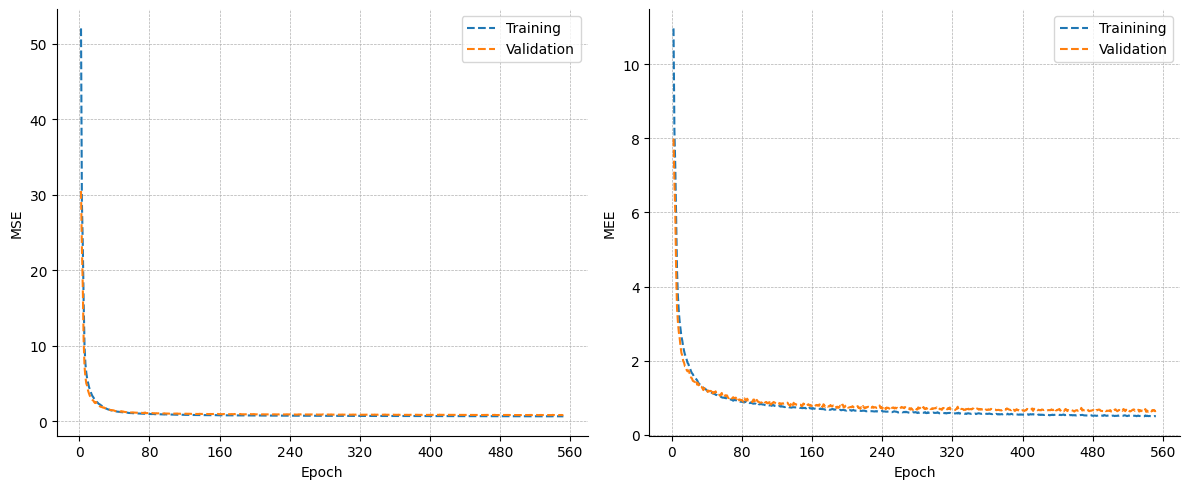

In [70]:
solver.plot_history(results_dir + '/CUP/history')

In [71]:
print('-- TRAINING --')
loss_train_cup, mee_train_cup = model_nn_sgd_cup.evaluate(x_train_cup, y_train_cup)
print(f'Loss (MSE): {loss_train_cup:.4f} -  MEE: {mee_train_cup:.4f}')

-- TRAINING --
25/25 [==============================] - 0s 1ms/step - loss: 0.6558 - mean_euclidean_error: 0.5031
Loss (MSE): 0.6558 -  MEE: 0.5031


In [72]:
print('-- VALIDATION --')
loss_val_cup, mee_val_cup = model_nn_sgd_cup.evaluate(x_val_cup, y_val_cup)
print(f'Loss (MSE): {loss_val_cup:.4f} -  MEE: {mee_val_cup:.4f}')

-- VALIDATION --
4/4 [==============================] - 0s 2ms/step - loss: 0.8135 - mean_euclidean_error: 0.6209
Loss (MSE): 0.8135 -  MEE: 0.6209


In [73]:
print('-- INTERNAL TEST --')
loss_internal_test_cup, mee_internal_test_cup = model_nn_sgd_cup.evaluate(x_internal_test_cup, y_internal_test_cup)
print(f'Loss (MSE): {loss_internal_test_cup:.4f} -  MEE: {mee_internal_test_cup:.4f}')

-- INTERNAL TEST --
4/4 [==============================] - 0s 2ms/step - loss: 0.7982 - mean_euclidean_error: 0.7235
Loss (MSE): 0.7982 -  MEE: 0.7235


## Blind Test Predictions

In [74]:
# Blind test set predictions
nn_sgd_preds_cup = model_nn_sgd_cup.predict(x_test_cup)

29/29 [==============================] - 0s 787us/step


## Store Result

In [76]:
report_nn_sgd = {
    'train': {'mse': loss_train_cup, 'mee': mee_train_cup},
    'val': {'mse': loss_val_cup, 'mee': mee_val_cup},
    'internal_test': {'mse': loss_internal_test_cup, 'mee': mee_internal_test_cup}
}

store_cup_result(results_dir + '/CUP/', report_nn_sgd, best_config, nn_sgd_preds_cup)